In [1]:
%matplotlib notebook
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
import nntools as nt

In [4]:
class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.MSE = nn.MSELoss()
    def criterion(self, y, d):
        return self.MSE(y, d)

In [5]:
vgg= tv.models.vgg19_bn(pretrained=True)

In [6]:
# Load the pre-trained SqueezeNet model.
dtype = torch.cuda.FloatTensor 
cnn = vgg.features
cnn.type(dtype)

# We don't want to train the model any further, so we don't want PyTorch to waste computation 
# computing gradients on parameters we're never going to update.
for param in cnn.parameters():
    param.requires_grad = False

In [7]:
img_dir = "photo.jpg"
img_path = os.path.join(img_dir)
y = Image.open(img_path).convert('RGB')

In [8]:
def tranform(y, image_size=(180, 180)):
    transform = tv.transforms.Compose([
        tv.transforms.Resize(image_size), #use torchvision(tv) to ressize it to the size indiated by image_size
        tv.transforms.ToTensor(),  #convert to a tensor
        tv.transforms.Normalize( (0.5, 0.5, 0.5), (0.5,0.5,0.5))   #normalize to the range [-1,1]
            ])
    y = transform(y)
    return y

In [14]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [9]:
y = tranform(y)
y = y[None,:,:,:]

In [10]:
y = y.cuda()

In [11]:
def extract_features(x, cnn):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A Tensor of shape (N, H, W, C) holding a minibatch of images that
      will be fed to the CNN.
    - cnn: A Tensorflow model that we will use to extract features.
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a Tensor of shape (N, H_i, W_i, C_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    features = []
    prev_feat = x
    for i, layer in enumerate( cnn._modules.values()):
        next_feat = layer(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features

In [ ]:
extract_features(x, cnn)[7].shape

In [17]:
x = torch.rand(y.shape).cuda()
x = nn.Parameter(x, requires_grad= True)
hy = extract_features(y, cnn)[3]
ha = extract_features(y, cnn)[7].view(128, 90*90)
Ga = torch.mm(ha, ha.t())
optimizer = torch.optim.Adam([x], lr = 0.001)
T = 5000
for t in range (0, T):
    optimizer.zero_grad()
    hx1 = extract_features(x, cnn)[3]
    hx2 = extract_features(x, cnn)[7].view(128, 90*90)
    Gx = torch.mm(hx2, hx2.t())
    loss = ( (hx1-hy)**2).mean() + 1000*((Gx-Ga)**2).sum()
    loss.backward(retain_graph=True)
    optimizer.step()

In [18]:
xx = (x.detach().cpu())
h = x.shape[2]
x = xx.view(3,h,-1)

<IPython.core.display.Javascript object>


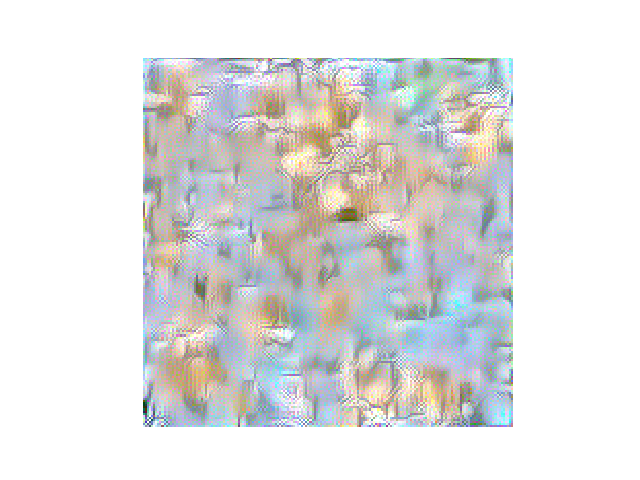

In [19]:
myimshow(x)

In [12]:
aimg_dir = "art.jpg"
aimg_path = os.path.join(aimg_dir)
a = Image.open(aimg_path).convert('RGB')
a = tranform(a)
a = a[None,:,:,:]
a = a.cuda()

In [ ]:
cnn